# **Stellar Object Classification**
_John Andrew Dixon_

---

#### **Data Dictionary**

|**Column Name**|**Description**| 
|-|-|
|obj_ID|Object Identifier, the unique value that identifies the object in the image catalog used by the CAS|
|alpha|Right Ascension angle (at J2000 epoch)|
|delta|Declination angle (at J2000 epoch)|
|u|Ultraviolet filter in the photometric system|
|g|Green filter in the photometric system|
|r|Red filter in the photometric system|
|i|Near Infrared filter in the photometric system|
|z|Infrared filter in the photometric system|
|run_ID|Run Number used to identify the specific scan|
|rereun_ID|Rerun Number to specify how the image was processed|
|cam_col|Camera column to identify the scanline within the run|
|field_ID|Field number to identify each field|
|spec_obj_ID|Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)|
|class|object class (galaxy, star or quasar object)|
|redshift|redshift value based on the increase in wavelength|
|plate|plate ID, identifies each plate in SDSS|
|MJD|Modified Julian Date, used to indicate when a given piece of SDSS data was taken|
|fiber_ID|fiber ID that identifies the fiber that pointed the light at the focal plane in each observation|

#### **Imports**

In [82]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
set_config(display="text")

#### **Data Loading**

In [2]:
# Remote url to the dataset
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRviGqwoVRVF_HY9LcyDLvVEDpdqZKvk1mL6K9xiWpEFh_i2QF4AX13P96L9F6nIAsD0iF0JZmcJ69A/pub?output=csv"
# Load the dataset.
df = pd.read_csv(url)
# Copy the loaded dataset so there is an origina copy and a copy to use for EDA and Machine Learning
stellar_df = df.copy()
# Verify it loaded
df.sample(5)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
81013,1.237654e+18,154.946281,60.000636,19.26756,18.28127,17.95560,17.81455,17.80880,2074,301,6,209,6.294922e+17,STAR,0.000027,559,52316,415
90227,1.237668e+18,241.731133,10.525465,19.82673,18.37856,17.65440,17.20844,16.91919,5322,301,5,213,2.844136e+18,GALAXY,0.077818,2526,54582,410
35848,1.237668e+18,214.889365,18.570968,18.03337,16.05855,15.07980,14.64488,14.30565,5194,301,1,652,3.106484e+18,GALAXY,0.065848,2759,54534,458
97518,1.237661e+18,71.040120,25.523901,25.10498,22.53728,20.39400,18.53493,17.40273,3559,301,4,63,1.847710e+18,STAR,-0.000036,1641,53032,392
84017,1.237664e+18,145.765656,33.188958,24.53088,23.17334,21.61934,20.51317,19.76299,4335,301,4,236,1.151578e+19,GALAXY,0.818484,10228,58223,275


#### **Helper Functions**

In [3]:
def format_for_df(keys, values):
   # Make the lambda function in a vectorized function so it can be used element wise
   formatter = np.vectorize(lambda x: f"{x:.3f}")
   # Create a dictionary out of the zipped object where the zipped object
   # is formed by zipping keys and the formatted values from the vectorized formatter function
   result = dict(zip([key[0] for key in keys], formatter(values))) 
   # Remove the first and last brackets for better formatted
   result = str(result)[1:-1]
   # Remove the single quotes
   return result.replace("'", "")

def metrics(train_y_true, train_y_pred, test_y_true, test_y_pred, name, labels=["GALAXY", "QSO", "STAR"]):
   # Create a metrics_df to hold the metrics
   metrics_df = pd.DataFrame(columns=["TRAIN ACCURACY", "TRAIN PRECISION", "TRAIN RECALL", "TEST ACCURACY", "TEST PRECISION", "TEST RECALL"])

   # Get the accuracy score
   train_accuracy = f"{accuracy_score(train_y_true, train_y_pred):.3f}"
   test_accuracy = f"{accuracy_score(test_y_true, test_y_pred):.3f}"

   # Get the precision scores per class when each is chosen as a positive class
   train_precisions = precision_score(train_y_true, train_y_pred, labels=labels, average=None)
   test_precisions = precision_score(test_y_true, test_y_pred, labels=labels, average=None)
   # Modify the format of the precision scores so they are easier to read and compare in the future
   train_precisions = format_for_df(labels, np.round(train_precisions, 3))
   test_precisions = format_for_df(labels, np.round(test_precisions, 3))

   # Get the recall scores per class when each is chosen as a positive class
   train_recalls = recall_score(train_y_true, train_y_pred, labels=labels, average=None)
   test_recalls = recall_score(test_y_true, test_y_pred, labels=labels, average=None)
   # Modify the format of the recall scores so they are easier to read and compare in the future
   train_recalls = format_for_df(labels, np.round(train_recalls, 3))
   test_recalls = format_for_df(labels, np.round(test_recalls, 3))

   # Add the metrics to the metrics_df
   metrics_df.loc[name] = [train_accuracy, train_precisions, train_recalls, test_accuracy, test_precisions, test_recalls]

   # Return the metrics_df
   return metrics_df

---
## **Explanatory Analysis**

#### **Cleaning**

**Duplicate check and removal:**

In [4]:
# Check for duplicates
stellar_df.duplicated().sum()

0

> There are no duplicates, meaning every row/sample of the original dataset represents a unique stellar object.

**Unnecessary column check and removal:**

In [5]:
# Check unique values of each column to see if any columns have only one value
stellar_df.nunique()

obj_ID         77332
alpha          99997
delta          99999
u              93748
g              92651
r              91901
i              92019
z              92007
run_ID           430
rerun_ID           1
cam_col            6
field_ID         856
spec_obj_ID    98431
class              3
redshift       94787
plate           6284
MJD             2180
fiber_ID        1000
dtype: int64

> As of right now, the only unnecessary column is `rerun_ID` because all 100,000 samples have the same value for this column. Keeping this column adds nothing.

In [6]:
# Drops the rerun_ID column
stellar_df.drop(columns="rerun_ID", inplace=True)

**Categorical Inconsistencies check and fix:**

In [7]:
# Check if the only categorical feature has inconsistencies.
stellar_df["class"].value_counts(normalize=True)

GALAXY    0.59445
STAR      0.21594
QSO       0.18961
Name: class, dtype: float64

> There are no categorical inconsistencies. Additionally, it's good to note that the classes are fairly unbalanced.

**Outlier check and fix:**

In [8]:
# Get summary stats to hopefully discern some outliers
stellar_df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237688e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,3.511610,186.130520,5.783893e+18,0.576661,5137.009660,55588.647500,449.312740
std,2.311265e+14,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,1.586912,149.011073,3.324026e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237669e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.240000e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


> There seem to be odd numbers within the `u`, `g`, and `z` features. All three have -9999 which does not seem to fit in with these features' stats. I'll explore further.

In [9]:
# Get the three features, sort them individually and reset their indices
u_desc = stellar_df[["u"]].sort_values(by="u", ascending=False).reset_index()
g_desc = stellar_df[["g"]].sort_values(by="g", ascending=False).reset_index()
z_desc = stellar_df[["z"]].sort_values(by="z", ascending=False).reset_index()
# Concatenate the three dataframes and output them
pd.concat([u_desc, g_desc, z_desc], axis=1)

,index,u,index,g,index,z
0,56693,32.78139,16115,31.60224,55524,29.383740
1,21245,30.66039,21245,30.60700,93321,28.790550
2,19525,29.32565,13023,29.86258,40201,28.238290
3,20225,29.23438,1735,28.90320,85950,27.805190
4,1046,29.19901,12673,28.20660,29689,27.673360
...,...,...,...,...,...,...
99995,75620,12.30349,14498,10.73097,75620,10.650560
99996,4472,12.26240,75620,10.67180,75784,10.441310
99997,75784,12.10168,4472,10.51139,4472,10.225510
99998,57763,10.99623,75784,10.49820,14498,9.612333


> It appears the -9999 in these three features is undoubtedly an outlier since it appears only once in all three features and the nearest number to it is a positive number. In fact, based on the outpute above, I believe these features should all be positive.

> There is not enough info present to fix the outlier. Likewise, it is the same row that has -9999 in all three features, as noted by the original index number. I'll remove it.

In [10]:
# Drop the row with index 79543 since this is the row with three outliers.
stellar_df.drop(79543, inplace=True)
stellar_df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,2,581,1.060000e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


**Identify and address missing values:**

In [11]:
# Check for missing values
stellar_df.isna().sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

> There are no missing values.

**Univariate visualizations:**

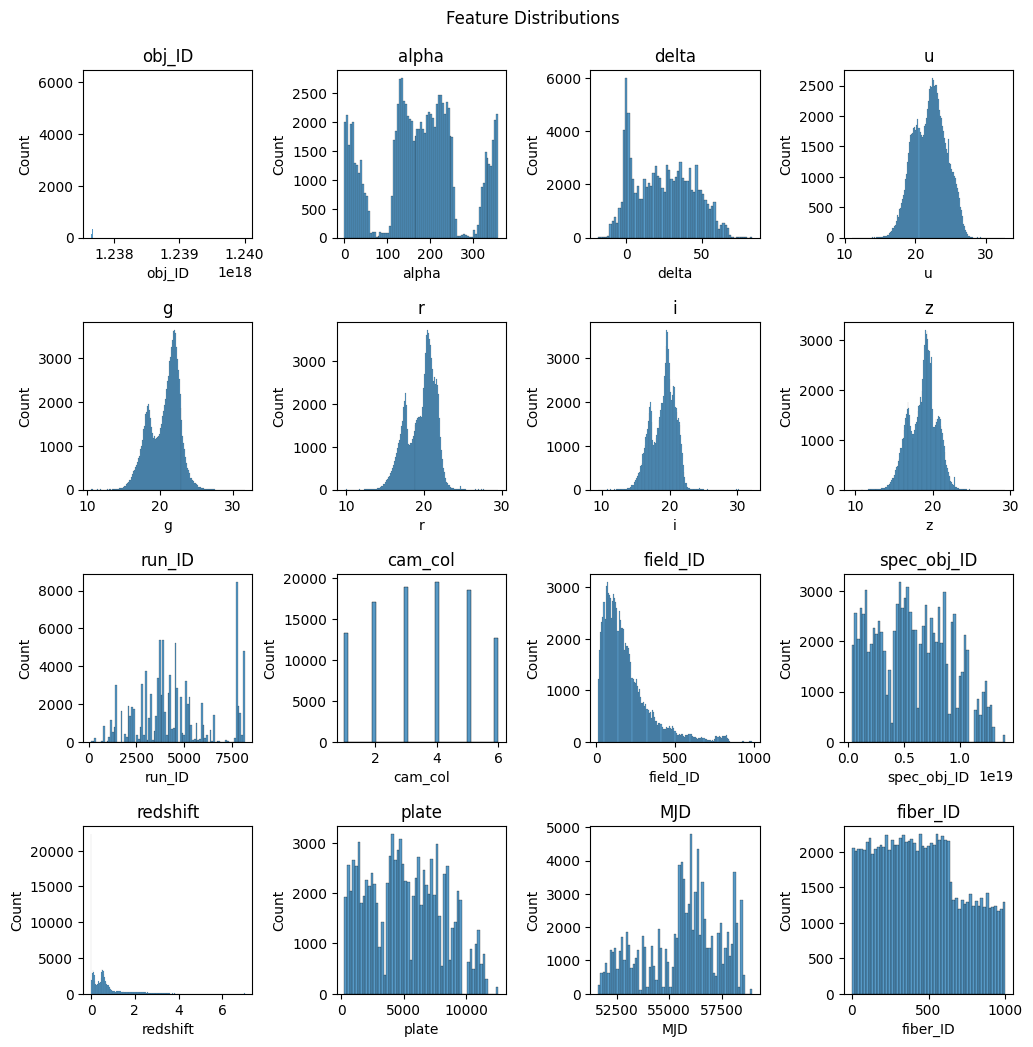

In [12]:
# Create a figure with 16 subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
# Get column names of the stellar_df DataFrame, except the class column
num_columns = stellar_df.drop(columns=["class"]).columns
# Make into a 4x4 list for easier processing in the below for-loop. I used the following to help me do this:
# https://stackoverflow.com/questions/27371064/converting-a-1d-list-into-a-2d-list-with-a-given-row-length-in-python
num_columns = [num_columns[i:i+4] for i in range(0, len(num_columns), 4)]
# Adjust the spacing of the subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)
# Add an overall title
plt.suptitle("Feature Distributions", y=0.93)
# Generate subplot histograms for all features
for row in range(4):
    for column in range(4):
        sns.histplot(data=stellar_df, x=num_columns[row][column], bins="auto", ax=axes[row, column]).set_title(f"{num_columns[row][column]}")

A few things are worth noting:
- `u`, `g`, `r`, `i`, and `z` all look similar in that they are not terribly skewed. However, all five are very much multimodal.
- `field_ID` and `redshift` are certainly skewed right.
- `obj_ID` has a distribution that is impossible to see or gauge. This is possibly because of its gargantuan numbers and the huge range between the lowest and smallest values. Since `obj_ID` is a composite of other values within the dataset I will most likely not even use it in the later machine learning preprocessing.
- `cam_col` consists of six discrete numbers.
- Some features, such as `alpha` and `z`, have three distinct sections (be it peaks or obvious distinctions within the histogram). I believe this might be because the `class` feature has three distinct values.

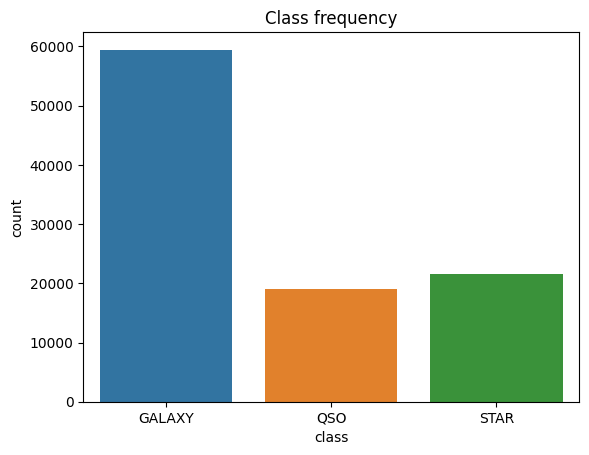

In [13]:
# Create a countplot to see the distribution of each class in the categorical "class" column
sns.countplot(data=stellar_df, x="class").set_title("Class frequency");

> Galaxies, by far, are more representative of the samples than the other two. Class balancing may be needed.

> Before moving further with analysis, it's worth noting that `obj_ID`, `spec_obj_ID`, and `plate` are columns where the data are composites of other column data. For example, `obj_ID` is composed of `run_ID`, `camcol`, and other columns. Due to these two columns being composites of other currently present data and the fact that their being IDs won't add to the overall analysis, I will remove them and continue with the analysis.

In [14]:
# Drop columns that had duplicate composite data
stellar_df.drop(columns=["obj_ID", "spec_obj_ID", "plate"], inplace=True)

**Multivariate Visuals**

Using a heatmap, identify correlations between features:

C:\Users\johna\AppData\Local\Temp\ipykernel_19356\199766924.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = round(stellar_df.corr(), 3)


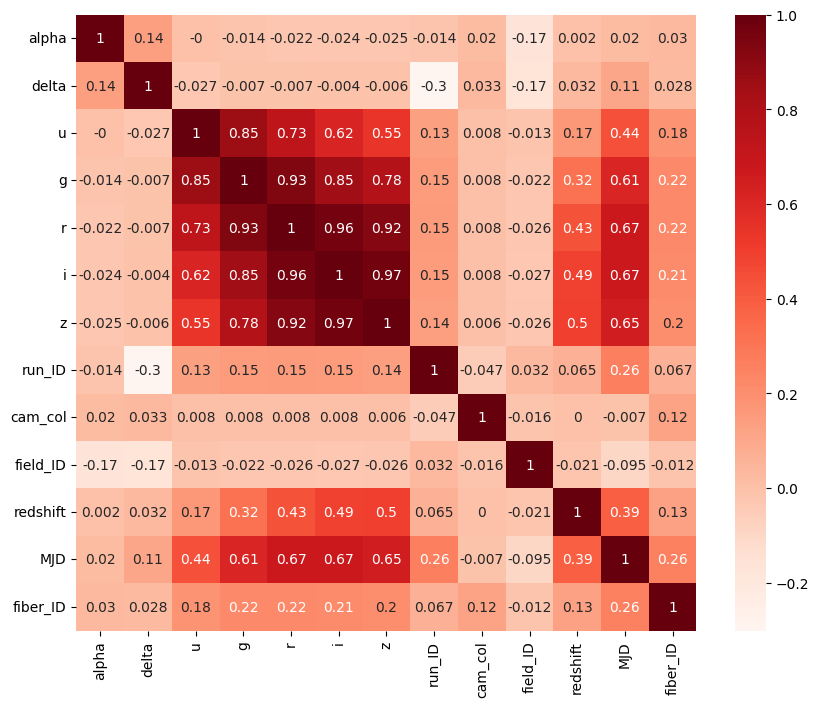

In [15]:
# Define figure size
plt.figure(figsize=(10, 8))
# correlations = round(stellar_df.corr(numeric_only=True), 3)
# Get the correlations
correlations = round(stellar_df.corr(), 3)
# Create a heatmap of the correlations with a red color scheme and annotations
sns.heatmap(correlations, cmap='Reds', annot=True);

> All photometric filters (`u`, `g`, `r`, `i`, `z`) are positively correlated with one another, be it moderate to strong. Though I am not an expert, I believe this might be because the more light that is received the more of _each_ type of light is detected.

> Likewise all photometric filters are positively correlated, to an extent, with `redshift`, and `MJD`. After looking through the documentation, I can't put a finger on why this is. A subject matter expert may be able to say why this is.

Exploratory visuals with a focus on how the filter features (`u`, `g`, `r`, `i`, `z`)and `redshift` orrelate with the proposed target:   

In [16]:
# Create a dataframe with only the filters, redshift, and class for easy analysis
filters_df = stellar_df[["u", "g", "r", "i", "z", "redshift", "class"]]
filters_df

,u,g,r,i,z,redshift,class
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,GALAXY
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,GALAXY
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,GALAXY
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,GALAXY
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,GALAXY
...,...,...,...,...,...,...,...
99995,22.16759,22.97586,21.90404,21.30548,20.73569,0.000000,GALAXY
99996,22.69118,22.38628,20.45003,19.75759,19.41526,0.404895,GALAXY
99997,21.16916,19.26997,18.20428,17.69034,17.35221,0.143366,GALAXY
99998,25.35039,21.63757,19.91386,19.07254,18.62482,0.455040,GALAXY


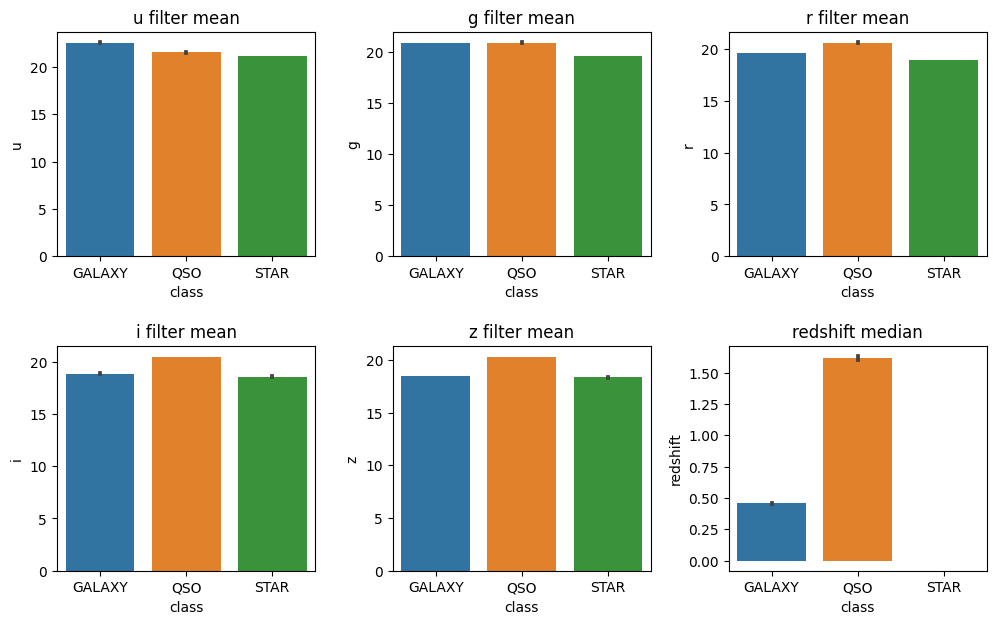

In [17]:
# Create a figure with subplots, specifically of two rows and three columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))
# Unravel the array of plots [2, 3] into [1, 5]
axes = axes.ravel()
# Loop through each coloumn of the filters dataframe, except the last which will be used below 
for i, column in enumerate(filters_df.columns[:-1]):
    # Since redshift is skewed, plot the median of the redshift when its the current column
    if column == "redshift":
        sns.barplot(data=filters_df, x="class", y=column, ax=axes[i], estimator="median").set_title("redshift median")
    # Since all the others are not skewed, take the mean of each of them
    else:
        sns.barplot(data=filters_df, x="class", y=column, ax=axes[i]).set_title(f"{column} filter mean")
# Adjust the spacing of the horizontal and vertical spaceing
plt.subplots_adjust(hspace=0.4, wspace=0.3)

> The five filters show subtle, though discernible differences across the target classes. The `redshift` feature has a clear difference across classes. I'll analyze two of the six visuals below.

### **Explanatory Visuals**

Text(0, 0.5, 'Infrared Light Level')

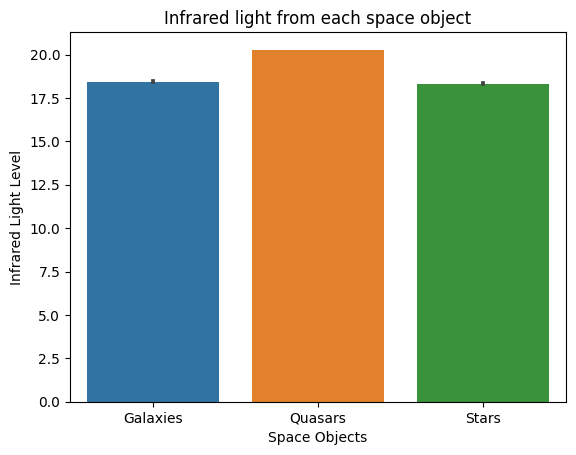

In [18]:
# Plot the level of infrared light detected on the infrared filter
sns.barplot(data=filters_df, x="class", y="z").set_title(f"Infrared light from each space object");
# Give it an xlabel
plt.xlabel("Space Objects")
# Change the names of the x ticks
plt.xticks(ticks=[0, 1, 2], labels=["Galaxies", "Quasars", "Stars"])
# Give it a y label
plt.ylabel("Infrared Light Level")

According to the plot above, quasars, on average, emit more infrared light than galaxies and stars. On average, stars emit the least amount of infrared light though galaxies aren't far behind.

So, if a sample has higher levels of infrared light than others it _might_ be a quasar.

> _**Note:** I looked through the SDSS website to figure out the units of the Infrared light as given in this dataset but I couldn't find one that made sense. All that's needed to know here is that the higher the number the more infrared light is present._

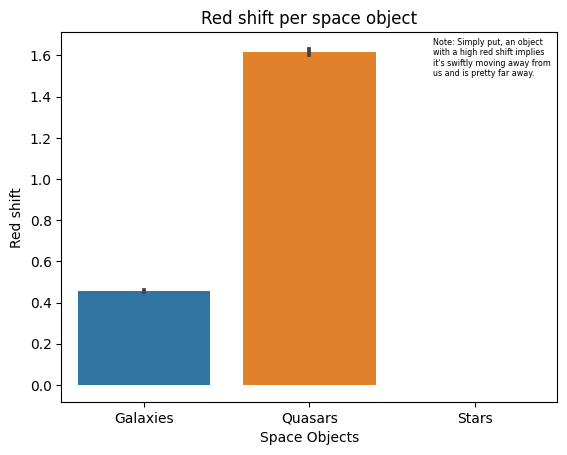

In [19]:
sns.barplot(data=filters_df, x="class", y="redshift", estimator="median").set_title(f"Red shift per space object")
# Give it an xlabel
plt.xlabel("Space Objects")
# Change the names of the x ticks
plt.xticks(ticks=[0, 1, 2], labels=["Galaxies", "Quasars", "Stars"])
# Give it a ylabel
plt.ylabel("Red shift")
# Add a necessary note
plt.text(1.75, 1.5, "Note: Simply put, an object\nwith a high red shift implies\nit's swiftly moving away from\nus and is pretty far away.", fontsize="xx-small");

Analyzing the plot above, quasars have the highest red shift, meaning the distance between us and them is growing larger and faster than the distance between us and stars and galaxies. Additionally, this means they're the furthest away from us. Stars within this dataset appear to remain stationary with respect to us.

So, undoubtedly, if a sample has a high red shift it most likely is a quasar.

> _**NOTE:** Red shift has no units as it is a ratio._

## **Predictive Analysis**

### **Preprocessing** 

For the predictive analysis portion, I'll choose four of the best classifiers that I know of: Random Forest Classifier, LGBM Classifier, XGBoost Classifier, and Gradient Boosting Classifier. Since these are tree-based, they don't require scaling. Additionally, there is no need to use any One-Hot Encoder or an Ordinal Encoder since none of the features are categorical in nature.

In [116]:
# Create the feature matrix
X = stellar_df.drop(columns=["class"])
# Create the target vector
y = stellar_df["class"]

In [117]:
# Create a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [118]:
# Create the dataframe to hold all the metrics. I put this in
# a separate cell since it'll be easier to reset in case something
# gets ruined.
metrics_df = pd.DataFrame()

### **Evaluation**

**_Random Forest Classifier Default_**

In [23]:
# Create a default RandomForestClassifier
rfc_default = RandomForestClassifier(random_state=42, n_jobs=-1)
# Fit it on the training data
rfc_default.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [119]:
# Get the current model metrics
current_metrics =  metrics(y_train, 
                           rfc_default.predict(X_train), 
                           y_test, 
                           rfc_default.predict(X_test), 
                           "Rand. Forest Default")
# Add the current model metrics to the metrics df
metrics_df = pd.concat([metrics_df, current_metrics])
metrics_df

,TRAIN ACCURACY,TRAIN PRECISION,TRAIN RECALL,TEST ACCURACY,TEST PRECISION,TEST RECALL
Rand. Forest Default,1.000,"G: 1.000, Q: 1.000, S: 1.000","G: 1.000, Q: 1.000, S: 1.000",0.979,"G: 0.978, Q: 0.968, S: 0.990","G: 0.987, Q: 0.930, S: 1.000"


**_Random Forest Classifier Tuned_**

In [26]:
# Create a simple param_grid to tune some of the hyperparameters
param_grid = {
    "n_estimators": [50, 75, 100, 125, 150],
    "max_depth": [None, 1, 10, 15, 20, 30]
}

# Instantiate the GridSearch
rfc_grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, n_jobs=-1)

# Fit the GridSearch and see which is best
rfc_grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 1, 10, 15, 20, 30],
                         'n_estimators': [50, 75, 100, 125, 150]})

In [120]:
# Get the best estimator
rfc_tuned = rfc_grid.best_estimator_
# Get the current model metrics
current_metrics =  metrics(y_train, 
                           rfc_tuned.predict(X_train), 
                           y_test, 
                           rfc_tuned.predict(X_test), 
                           "Rand. Forest Tuned")
# Add the current model metrics to the metrics df
metrics_df = pd.concat([metrics_df, current_metrics])
metrics_df

,TRAIN ACCURACY,TRAIN PRECISION,TRAIN RECALL,TEST ACCURACY,TEST PRECISION,TEST RECALL
Rand. Forest Default,1.000,"G: 1.000, Q: 1.000, S: 1.000","G: 1.000, Q: 1.000, S: 1.000",0.979,"G: 0.978, Q: 0.968, S: 0.990","G: 0.987, Q: 0.930, S: 1.000"
Rand. Forest Tuned,0.992,"G: 0.989, Q: 0.993, S: 0.999","G: 0.998, Q: 0.966, S: 1.000",0.978,"G: 0.977, Q: 0.967, S: 0.990","G: 0.986, Q: 0.928, S: 1.000"


**_Gradient Boosting Classifier Default_**

In [30]:
# Create default Gradient Boosting Classifier
gbc_default = GradientBoostingClassifier(random_state=42)
# Fit to the training data
gbc_default.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [121]:
# Get the current model metrics
current_metrics =  metrics(y_train, 
                           gbc_default.predict(X_train), 
                           y_test, 
                           gbc_default.predict(X_test), 
                           "Grad. Boosting Default")
# Add the current model metrics to the metrics df
metrics_df = pd.concat([metrics_df, current_metrics])
metrics_df

,TRAIN ACCURACY,TRAIN PRECISION,TRAIN RECALL,TEST ACCURACY,TEST PRECISION,TEST RECALL
Rand. Forest Default,1.000,"G: 1.000, Q: 1.000, S: 1.000","G: 1.000, Q: 1.000, S: 1.000",0.979,"G: 0.978, Q: 0.968, S: 0.990","G: 0.987, Q: 0.930, S: 1.000"
Rand. Forest Tuned,0.992,"G: 0.989, Q: 0.993, S: 0.999","G: 0.998, Q: 0.966, S: 1.000",0.978,"G: 0.977, Q: 0.967, S: 0.990","G: 0.986, Q: 0.928, S: 1.000"
Grad. Boosting Default,0.978,"G: 0.975, Q: 0.965, S: 0.997","G: 0.988, Q: 0.921, S: 0.999",0.976,"G: 0.973, Q: 0.962, S: 0.996","G: 0.987, Q: 0.917, S: 0.999"


**_Gradient Boosting Classifier Tuned_**

In [48]:
# Create a simple param_grid to tune some of the hyperparameters
param_grid = {
    "n_estimators": [50, 100, 150, 200, 250],
    "max_depth": [1, 2, 3, 4, 5]
}

# Instantiate the GridSearch
gbc_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, n_jobs=-1)

# Fit the GridSearch and see which is best
gbc_grid.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [50, 100, 150, 200, 250]})

In [122]:
# Get the best estimator
gbc_tuned = gbc_grid.best_estimator_
# Get the current model metrics
current_metrics =  metrics(y_train, 
                           gbc_tuned.predict(X_train), 
                           y_test, 
                           gbc_tuned.predict(X_test), 
                           "Grad. Boosting Tuned")
# Add the current model metrics to the metrics df
metrics_df = pd.concat([metrics_df, current_metrics])
metrics_df

,TRAIN ACCURACY,TRAIN PRECISION,TRAIN RECALL,TEST ACCURACY,TEST PRECISION,TEST RECALL
Rand. Forest Default,1.000,"G: 1.000, Q: 1.000, S: 1.000","G: 1.000, Q: 1.000, S: 1.000",0.979,"G: 0.978, Q: 0.968, S: 0.990","G: 0.987, Q: 0.930, S: 1.000"
Rand. Forest Tuned,0.992,"G: 0.989, Q: 0.993, S: 0.999","G: 0.998, Q: 0.966, S: 1.000",0.978,"G: 0.977, Q: 0.967, S: 0.990","G: 0.986, Q: 0.928, S: 1.000"
Grad. Boosting Default,0.978,"G: 0.975, Q: 0.965, S: 0.997","G: 0.988, Q: 0.921, S: 0.999",0.976,"G: 0.973, Q: 0.962, S: 0.996","G: 0.987, Q: 0.917, S: 0.999"
Grad. Boosting Tuned,0.983,"G: 0.982, Q: 0.971, S: 0.998","G: 0.990, Q: 0.942, S: 1.000",0.977,"G: 0.976, Q: 0.959, S: 0.996","G: 0.986, Q: 0.926, S: 0.999"


**_LightGBM Classifier Default_**

In [33]:
# Create default LightGBM Classifier
lgbmc_default = LGBMClassifier(random_state=42, n_jobs=-1)
# Fit to the training data
lgbmc_default.fit(X_train, y_train)

LGBMClassifier(random_state=42)

In [123]:
# Get the current model metrics
current_metrics =  metrics(y_train, 
                           lgbmc_default.predict(X_train), 
                           y_test, 
                           lgbmc_default.predict(X_test), 
                           "LightGBM Default")
# Add the current model metrics to the metrics df
metrics_df = pd.concat([metrics_df, current_metrics])
metrics_df

,TRAIN ACCURACY,TRAIN PRECISION,TRAIN RECALL,TEST ACCURACY,TEST PRECISION,TEST RECALL
Rand. Forest Default,1.000,"G: 1.000, Q: 1.000, S: 1.000","G: 1.000, Q: 1.000, S: 1.000",0.979,"G: 0.978, Q: 0.968, S: 0.990","G: 0.987, Q: 0.930, S: 1.000"
Rand. Forest Tuned,0.992,"G: 0.989, Q: 0.993, S: 0.999","G: 0.998, Q: 0.966, S: 1.000",0.978,"G: 0.977, Q: 0.967, S: 0.990","G: 0.986, Q: 0.928, S: 1.000"
Grad. Boosting Default,0.978,"G: 0.975, Q: 0.965, S: 0.997","G: 0.988, Q: 0.921, S: 0.999",0.976,"G: 0.973, Q: 0.962, S: 0.996","G: 0.987, Q: 0.917, S: 0.999"
Grad. Boosting Tuned,0.983,"G: 0.982, Q: 0.971, S: 0.998","G: 0.990, Q: 0.942, S: 1.000",0.977,"G: 0.976, Q: 0.959, S: 0.996","G: 0.986, Q: 0.926, S: 0.999"
LightGBM Default,0.985,"G: 0.983, Q: 0.973, S: 1.000","G: 0.992, Q: 0.946, S: 1.000",0.979,"G: 0.978, Q: 0.961, S: 0.995","G: 0.986, Q: 0.932, S: 0.999"


**_LightGBM Classifier Tuned_**

In [57]:
# Create a simple param_grid to tune some of the hyperparameters
param_grid = {
    "n_estimators": [50, 100, 150, 200, 250],
    "max_depth": [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "num_leaves": [20, 25, 31, 35, 40, 45, 50]
}

# Instantiate the GridSearch
lgbmc_grid = GridSearchCV(LGBMClassifier(random_state=42, n_jobs=-1), param_grid, n_jobs=-1)

# Fit the GridSearch and see which is best
lgbmc_grid.fit(X_train, y_train)

GridSearchCV(estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [50, 100, 150, 200, 250],
                         'num_leaves': [20, 25, 31, 35, 40, 45, 50]})

In [124]:
# Get the best estimator
lgbmc_tuned = lgbmc_grid.best_estimator_
# Get the current model metrics
current_metrics =  metrics(y_train, 
                           lgbmc_tuned.predict(X_train), 
                           y_test, 
                           lgbmc_tuned.predict(X_test), 
                           "LightGBM Tuned")
# Add the current model metrics to the metrics df
metrics_df = pd.concat([metrics_df, current_metrics])
metrics_df

,TRAIN ACCURACY,TRAIN PRECISION,TRAIN RECALL,TEST ACCURACY,TEST PRECISION,TEST RECALL
Rand. Forest Default,1.000,"G: 1.000, Q: 1.000, S: 1.000","G: 1.000, Q: 1.000, S: 1.000",0.979,"G: 0.978, Q: 0.968, S: 0.990","G: 0.987, Q: 0.930, S: 1.000"
Rand. Forest Tuned,0.992,"G: 0.989, Q: 0.993, S: 0.999","G: 0.998, Q: 0.966, S: 1.000",0.978,"G: 0.977, Q: 0.967, S: 0.990","G: 0.986, Q: 0.928, S: 1.000"
Grad. Boosting Default,0.978,"G: 0.975, Q: 0.965, S: 0.997","G: 0.988, Q: 0.921, S: 0.999",0.976,"G: 0.973, Q: 0.962, S: 0.996","G: 0.987, Q: 0.917, S: 0.999"
Grad. Boosting Tuned,0.983,"G: 0.982, Q: 0.971, S: 0.998","G: 0.990, Q: 0.942, S: 1.000",0.977,"G: 0.976, Q: 0.959, S: 0.996","G: 0.986, Q: 0.926, S: 0.999"
LightGBM Default,0.985,"G: 0.983, Q: 0.973, S: 1.000","G: 0.992, Q: 0.946, S: 1.000",0.979,"G: 0.978, Q: 0.961, S: 0.995","G: 0.986, Q: 0.932, S: 0.999"
LightGBM Tuned,0.995,"G: 0.994, Q: 0.993, S: 1.000","G: 0.998, Q: 0.980, S: 1.000",0.979,"G: 0.978, Q: 0.964, S: 0.995","G: 0.987, Q: 0.932, S: 0.999"


**_XGBoost Classifier Default_**

In [36]:
# Prepare data for XGBoost
y_train_XG = y_train.map({"GALAXY": 0, "QSO": 1, "STAR": 2})
y_test_XG = y_test.map({"GALAXY": 0, "QSO": 1, "STAR": 2})

In [37]:
# Create default XGBoost Classifier
xgbc_default = XGBClassifier()
# Fit on the training data
xgbc_default.fit(X_train, y_train_XG)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [125]:
# Perform predictions on both of these sets, but do it this way because XGBoost is odd
y_train_preds = xgbc_default.predict(X_train)
y_train_preds = pd.Series(y_train_preds).map({0: "GALAXY", 1: "QSO", 2: "STAR"})
y_test_preds = xgbc_default.predict(X_test)
y_test_preds = pd.Series(y_test_preds).map({0: "GALAXY", 1: "QSO", 2: "STAR"})

metrics_df = pd.concat([metrics_df, metrics(y_train, y_train_preds, y_test, y_test_preds, "XGBoost Default")])
metrics_df

,TRAIN ACCURACY,TRAIN PRECISION,TRAIN RECALL,TEST ACCURACY,TEST PRECISION,TEST RECALL
Rand. Forest Default,1.000,"G: 1.000, Q: 1.000, S: 1.000","G: 1.000, Q: 1.000, S: 1.000",0.979,"G: 0.978, Q: 0.968, S: 0.990","G: 0.987, Q: 0.930, S: 1.000"
Rand. Forest Tuned,0.992,"G: 0.989, Q: 0.993, S: 0.999","G: 0.998, Q: 0.966, S: 1.000",0.978,"G: 0.977, Q: 0.967, S: 0.990","G: 0.986, Q: 0.928, S: 1.000"
Grad. Boosting Default,0.978,"G: 0.975, Q: 0.965, S: 0.997","G: 0.988, Q: 0.921, S: 0.999",0.976,"G: 0.973, Q: 0.962, S: 0.996","G: 0.987, Q: 0.917, S: 0.999"
Grad. Boosting Tuned,0.983,"G: 0.982, Q: 0.971, S: 0.998","G: 0.990, Q: 0.942, S: 1.000",0.977,"G: 0.976, Q: 0.959, S: 0.996","G: 0.986, Q: 0.926, S: 0.999"
LightGBM Default,0.985,"G: 0.983, Q: 0.973, S: 1.000","G: 0.992, Q: 0.946, S: 1.000",0.979,"G: 0.978, Q: 0.961, S: 0.995","G: 0.986, Q: 0.932, S: 0.999"
LightGBM Tuned,0.995,"G: 0.994, Q: 0.993, S: 1.000","G: 0.998, Q: 0.980, S: 1.000",0.979,"G: 0.978, Q: 0.964, S: 0.995","G: 0.987, Q: 0.932, S: 0.999"
XGBoost Default,0.991,"G: 0.988, Q: 0.987, S: 1.000","G: 0.996, Q: 0.964, S: 1.000",0.979,"G: 0.978, Q: 0.963, S: 0.996","G: 0.987, Q: 0.932, S: 1.000"


**_XGBoost Classifier Tuned_**

In [64]:
# Create a simple param_grid to tune some of the hyperparameters
param_grid = {
    "n_estimators": [50, 100, 150, 200, 250],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

# Instantiate the GridSearch
xgbc_grid = GridSearchCV(XGBClassifier(random_state=42, n_jobs=-1), param_grid, n_jobs=-1)

# Fit the GridSearch and see which is best
xgbc_grid.fit(X_train, y_train_XG)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_c

In [126]:
xgbc_tuned = xgbc_grid.best_estimator_
# Perform predictions on both of these sets, but do it this way because XGBoost is odd
y_train_preds = xgbc_tuned.predict(X_train)
y_train_preds = pd.Series(y_train_preds).map({0: "GALAXY", 1: "QSO", 2: "STAR"})
y_test_preds = xgbc_tuned.predict(X_test)
y_test_preds = pd.Series(y_test_preds).map({0: "GALAXY", 1: "QSO", 2: "STAR"})

metrics_df = pd.concat([metrics_df, metrics(y_train, y_train_preds, y_test, y_test_preds, "XGBoost Tuned")])
metrics_df

,TRAIN ACCURACY,TRAIN PRECISION,TRAIN RECALL,TEST ACCURACY,TEST PRECISION,TEST RECALL
Rand. Forest Default,1.000,"G: 1.000, Q: 1.000, S: 1.000","G: 1.000, Q: 1.000, S: 1.000",0.979,"G: 0.978, Q: 0.968, S: 0.990","G: 0.987, Q: 0.930, S: 1.000"
Rand. Forest Tuned,0.992,"G: 0.989, Q: 0.993, S: 0.999","G: 0.998, Q: 0.966, S: 1.000",0.978,"G: 0.977, Q: 0.967, S: 0.990","G: 0.986, Q: 0.928, S: 1.000"
Grad. Boosting Default,0.978,"G: 0.975, Q: 0.965, S: 0.997","G: 0.988, Q: 0.921, S: 0.999",0.976,"G: 0.973, Q: 0.962, S: 0.996","G: 0.987, Q: 0.917, S: 0.999"
Grad. Boosting Tuned,0.983,"G: 0.982, Q: 0.971, S: 0.998","G: 0.990, Q: 0.942, S: 1.000",0.977,"G: 0.976, Q: 0.959, S: 0.996","G: 0.986, Q: 0.926, S: 0.999"
LightGBM Default,0.985,"G: 0.983, Q: 0.973, S: 1.000","G: 0.992, Q: 0.946, S: 1.000",0.979,"G: 0.978, Q: 0.961, S: 0.995","G: 0.986, Q: 0.932, S: 0.999"
LightGBM Tuned,0.995,"G: 0.994, Q: 0.993, S: 1.000","G: 0.998, Q: 0.980, S: 1.000",0.979,"G: 0.978, Q: 0.964, S: 0.995","G: 0.987, Q: 0.932, S: 0.999"
XGBoost Default,0.991,"G: 0.988, Q: 0.987, S: 1.000","G: 0.996, Q: 0.964, S: 1.000",0.979,"G: 0.978, Q: 0.963, S: 0.996","G: 0.987, Q: 0.932, S: 1.000"
XGBoost Tuned,1.000,"G: 1.000, Q: 1.000, S: 1.000","G: 1.000, Q: 1.000, S: 1.000",0.980,"G: 0.978, Q: 0.968, S: 0.997","G: 0.989, Q: 0.931, S: 1.000"


**_Principal Component Analysis_**

In [83]:
xgbc_grid.best_params_

{'max_depth': 9, 'n_estimators': 250}

In [85]:
pca_pipe = make_pipeline(PCA(n_components=0.95), XGBClassifier(max_depth=9, n_estimators=250, random_state=42, n_jobs=-1))
pca_pipe.fit(X_train, y_train_XG)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=2

In [127]:
# Perform predictions on both of these sets, but do it this way because XGBoost is odd
y_train_preds = pca_pipe.predict(X_train)
y_train_preds = pd.Series(y_train_preds).map({0: "GALAXY", 1: "QSO", 2: "STAR"})
y_test_preds = pca_pipe.predict(X_test)
y_test_preds = pd.Series(y_test_preds).map({0: "GALAXY", 1: "QSO", 2: "STAR"})

metrics_df = pd.concat([metrics_df, metrics(y_train, y_train_preds, y_test, y_test_preds, "XGBoost PCA")])
metrics_df

,TRAIN ACCURACY,TRAIN PRECISION,TRAIN RECALL,TEST ACCURACY,TEST PRECISION,TEST RECALL
Rand. Forest Default,1.000,"G: 1.000, Q: 1.000, S: 1.000","G: 1.000, Q: 1.000, S: 1.000",0.979,"G: 0.978, Q: 0.968, S: 0.990","G: 0.987, Q: 0.930, S: 1.000"
Rand. Forest Tuned,0.992,"G: 0.989, Q: 0.993, S: 0.999","G: 0.998, Q: 0.966, S: 1.000",0.978,"G: 0.977, Q: 0.967, S: 0.990","G: 0.986, Q: 0.928, S: 1.000"
Grad. Boosting Default,0.978,"G: 0.975, Q: 0.965, S: 0.997","G: 0.988, Q: 0.921, S: 0.999",0.976,"G: 0.973, Q: 0.962, S: 0.996","G: 0.987, Q: 0.917, S: 0.999"
Grad. Boosting Tuned,0.983,"G: 0.982, Q: 0.971, S: 0.998","G: 0.990, Q: 0.942, S: 1.000",0.977,"G: 0.976, Q: 0.959, S: 0.996","G: 0.986, Q: 0.926, S: 0.999"
LightGBM Default,0.985,"G: 0.983, Q: 0.973, S: 1.000","G: 0.992, Q: 0.946, S: 1.000",0.979,"G: 0.978, Q: 0.961, S: 0.995","G: 0.986, Q: 0.932, S: 0.999"
LightGBM Tuned,0.995,"G: 0.994, Q: 0.993, S: 1.000","G: 0.998, Q: 0.980, S: 1.000",0.979,"G: 0.978, Q: 0.964, S: 0.995","G: 0.987, Q: 0.932, S: 0.999"
XGBoost Default,0.991,"G: 0.988, Q: 0.987, S: 1.000","G: 0.996, Q: 0.964, S: 1.000",0.979,"G: 0.978, Q: 0.963, S: 0.996","G: 0.987, Q: 0.932, S: 1.000"
XGBoost Tuned,1.000,"G: 1.000, Q: 1.000, S: 1.000","G: 1.000, Q: 1.000, S: 1.000",0.980,"G: 0.978, Q: 0.968, S: 0.997","G: 0.989, Q: 0.931, S: 1.000"
XGBoost PCA,0.794,"G: 0.782, Q: 0.739, S: 0.921","G: 0.960, Q: 0.554, S: 0.548",0.705,"G: 0.729, Q: 0.524, S: 0.774","G: 0.903, Q: 0.393, S: 0.433"


**_Feature Engineering_**

In [129]:
stellar_engineered_df = stellar_df.copy()
stellar_engineered_df["filters"] = (stellar_df["u"] + stellar_df["g"] + stellar_df["i"] + stellar_df["r"] + stellar_df["z"])/5
stellar_engineered_df.drop(columns=["u", "g", "r", "i", "z"], inplace=True)
stellar_engineered_df

,alpha,delta,run_ID,cam_col,field_ID,class,redshift,MJD,fiber_ID,filters
0,135.689107,32.494632,3606,2,79,GALAXY,0.634794,56354,171,20.901714
1,144.826101,31.274185,4518,5,119,GALAXY,0.779136,58158,427,22.595260
2,142.188790,35.582444,3606,2,120,GALAXY,0.644195,55592,299,21.366712
3,338.741038,-0.402828,4192,3,214,GALAXY,0.932346,58039,775,21.455928
4,345.282593,21.183866,8102,3,137,GALAXY,0.116123,56187,842,17.007330
...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,7778,2,581,GALAXY,0.000000,57749,438,21.817732
99996,29.493819,19.798874,7917,1,289,GALAXY,0.404895,56934,866,20.940068
99997,224.587407,15.700707,5314,4,308,GALAXY,0.143366,54535,74,18.737192
99998,212.268621,46.660365,3650,4,131,GALAXY,0.455040,56368,470,20.919836


In [130]:
# Create a train-test split
X = stellar_engineered_df.drop(columns=["class"])
y = stellar_engineered_df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [131]:
# Prepare data for XGBoost
y_train_XG = y_train.map({"GALAXY": 0, "QSO": 1, "STAR": 2})
y_test_XG = y_test.map({"GALAXY": 0, "QSO": 1, "STAR": 2})

In [133]:
xgbc_tuned_engineered = XGBClassifier(max_depth=9, n_estimators=250, random_state=42, n_jobs=-1)
xgbc_tuned_engineered.fit(X_train, y_train_XG)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [134]:
# Perform predictions on both of these sets, but do it this way because XGBoost is odd
y_train_preds = xgbc_tuned_engineered.predict(X_train)
y_train_preds = pd.Series(y_train_preds).map({0: "GALAXY", 1: "QSO", 2: "STAR"})
y_test_preds = xgbc_tuned_engineered.predict(X_test)
y_test_preds = pd.Series(y_test_preds).map({0: "GALAXY", 1: "QSO", 2: "STAR"})

metrics_df = pd.concat([metrics_df, metrics(y_train, y_train_preds, y_test, y_test_preds, "XGBoost FE")])
metrics_df

,TRAIN ACCURACY,TRAIN PRECISION,TRAIN RECALL,TEST ACCURACY,TEST PRECISION,TEST RECALL
Rand. Forest Default,1.000,"G: 1.000, Q: 1.000, S: 1.000","G: 1.000, Q: 1.000, S: 1.000",0.979,"G: 0.978, Q: 0.968, S: 0.990","G: 0.987, Q: 0.930, S: 1.000"
Rand. Forest Tuned,0.992,"G: 0.989, Q: 0.993, S: 0.999","G: 0.998, Q: 0.966, S: 1.000",0.978,"G: 0.977, Q: 0.967, S: 0.990","G: 0.986, Q: 0.928, S: 1.000"
Grad. Boosting Default,0.978,"G: 0.975, Q: 0.965, S: 0.997","G: 0.988, Q: 0.921, S: 0.999",0.976,"G: 0.973, Q: 0.962, S: 0.996","G: 0.987, Q: 0.917, S: 0.999"
Grad. Boosting Tuned,0.983,"G: 0.982, Q: 0.971, S: 0.998","G: 0.990, Q: 0.942, S: 1.000",0.977,"G: 0.976, Q: 0.959, S: 0.996","G: 0.986, Q: 0.926, S: 0.999"
LightGBM Default,0.985,"G: 0.983, Q: 0.973, S: 1.000","G: 0.992, Q: 0.946, S: 1.000",0.979,"G: 0.978, Q: 0.961, S: 0.995","G: 0.986, Q: 0.932, S: 0.999"
LightGBM Tuned,0.995,"G: 0.994, Q: 0.993, S: 1.000","G: 0.998, Q: 0.980, S: 1.000",0.979,"G: 0.978, Q: 0.964, S: 0.995","G: 0.987, Q: 0.932, S: 0.999"
XGBoost Default,0.991,"G: 0.988, Q: 0.987, S: 1.000","G: 0.996, Q: 0.964, S: 1.000",0.979,"G: 0.978, Q: 0.963, S: 0.996","G: 0.987, Q: 0.932, S: 1.000"
XGBoost Tuned,1.000,"G: 1.000, Q: 1.000, S: 1.000","G: 1.000, Q: 1.000, S: 1.000",0.980,"G: 0.978, Q: 0.968, S: 0.997","G: 0.989, Q: 0.931, S: 1.000"
XGBoost PCA,0.794,"G: 0.782, Q: 0.739, S: 0.921","G: 0.960, Q: 0.554, S: 0.548",0.705,"G: 0.729, Q: 0.524, S: 0.774","G: 0.903, Q: 0.393, S: 0.433"
XGBoost FE,1.000,"G: 1.000, Q: 1.000, S: 1.000","G: 1.000, Q: 1.000, S: 1.000",0.971,"G: 0.966, Q: 0.956, S: 0.997","G: 0.986, Q: 0.892, S: 0.999"


**_Results_**